In [1]:
import imgaug.augmenters as iaa
import imgaug
import os
import pandas as pd
import skimage
from sklearn.utils import shuffle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from moles_large import MolesConfig

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3

In [2]:
ORIG_TRAIN_DIR = "data/large/train_o"
AUG_TRAIN_DIR = "data/large/train"

In [3]:
config = MolesConfig()

In [4]:
# Get all the training files
train_image_files = os.listdir(ORIG_TRAIN_DIR +"/images/")
train_ids = [f[:12] for f in train_image_files]

In [5]:
len(train_image_files)

2000

In [6]:
# Read in the ground truth file
gt = pd.read_csv("data/ISIC-2017_Training_Part3_GroundTruth.csv")
gt["label"] = (gt["melanoma"] * 1 + gt["seborrheic_keratosis"] * 2) + 1

In [7]:
# Filter gts dataframe to just the training images
train_gt = gt[gt["image_id"].isin(train_ids)]

# And then into each label category
nevus_gt = train_gt[train_gt["label"] == 1]
melanoma_gt = train_gt[train_gt["label"] == 2]
sk_gt = train_gt[train_gt["label"] == 3]

In [14]:
# Number of times to iterate over these image type
nevus_iter = 2
melanoma_iter = 10
sk_iter = 15

In [15]:
print(len(nevus_gt)* (nevus_iter + 1)) 
print(len(melanoma_gt)* (melanoma_iter + 1)) 
print(len(sk_gt)* (sk_iter + 1)) 

4116
4114
4064


In [16]:
# Augmentations to use 
augmentation = iaa.SomeOf((1,9), [
    iaa.Fliplr(1.0),
    iaa.OneOf([
        iaa.GaussianBlur((1, 6.0)),
        iaa.AverageBlur(k=(1, 3)),
        iaa.MedianBlur(k=(3, 5)),
    ]),
    iaa.Flipud(1.0),
    iaa.Rot90((1,3)),
    iaa.CropAndPad(percent=(-0.25, 0.25)),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.2),
    iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),
               iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),]),
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.LinearContrast((0.75, 1.5)),
], random_order=True)

MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                    "Fliplr", "Flipud", "CropAndPad",
                    "Affine", "PiecewiseAffine", "Rot90", "CoarseDropout"]
    
def hook(images, augmenter, parents, default):
        """Determines which augmenters to apply to masks."""
        return augmenter.__class__.__name__ in MASK_AUGMENTERS

In [20]:
# Sample augmentations
ix = 12
image_id = train_ids[ix]

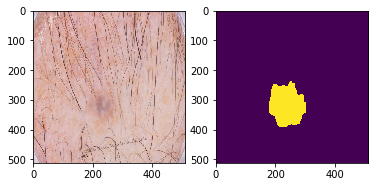

In [21]:
image = skimage.io.imread(ORIG_TRAIN_DIR + "/images/{}.jpg".format(image_id))
image = cv2.resize(image, (config.IMAGE_MIN_DIM, config.IMAGE_MIN_DIM))
mask = skimage.io.imread(ORIG_TRAIN_DIR + "/masks/{}_segmentation.png".format(image_id))
mask = cv2.resize(mask, (config.IMAGE_MIN_DIM, config.IMAGE_MIN_DIM))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)

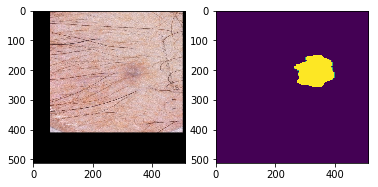

In [22]:
det = augmentation.to_deterministic()
image_aug = det.augment_image(image)
mask_aug = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))

plt.subplot(1,2,1)
plt.imshow(image_aug)
plt.subplot(1,2,2)
plt.imshow(mask_aug)

In [23]:
def aug_image(image_id, augmentation, label):
    global counter
    
    image = skimage.io.imread(ORIG_TRAIN_DIR + "/images/{}.jpg".format(image_id))
    image = cv2.resize(image, (config.IMAGE_MIN_DIM, config.IMAGE_MIN_DIM))
    
    mask = skimage.io.imread(ORIG_TRAIN_DIR + "/masks/{}_segmentation.png".format(image_id))
    mask = cv2.resize(mask, (config.IMAGE_MIN_DIM, config.IMAGE_MIN_DIM))
    
    new_image_id = "ISIC_{:07}".format(counter)
    
    def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS
    
    if augmentation:
        det = augmentation.to_deterministic()

        image_aug = det.augment_image(image)

        mask_aug = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        skimage.io.imsave(AUG_TRAIN_DIR + "/images/{}.jpg".format(new_image_id), image_aug)
        skimage.io.imsave(AUG_TRAIN_DIR + "/masks/{}_segmentation.png".format(new_image_id), mask_aug)
    else:
        # No augmentation so just write the origincal image and mask
        skimage.io.imsave(AUG_TRAIN_DIR + "/images/{}.jpg".format(new_image_id), image)
        skimage.io.imsave(AUG_TRAIN_DIR + "/masks/{}_segmentation.png".format(new_image_id), mask)
        
    # Update lists of ids and labels as well as the counter
    augmented_X.append(new_image_id)
    augmented_y.append(label)
    counter += 1
    
    #plt.subplot(2,2,1)
    #plt.imshow(image)
    #plt.subplot(2,2,2)
    #plt.imshow(mask)
    #plt.subplot(2,2,3)
    #plt.imshow(image_aug)
    #plt.subplot(2,2,4)
    #plt.imshow(mask_aug)

In [24]:
X = nevus_gt["image_id"].tolist() * nevus_iter + \
    melanoma_gt["image_id"].tolist() * melanoma_iter + \
    sk_gt["image_id"].tolist() * sk_iter

y = nevus_gt["label"].tolist() * nevus_iter + \
    melanoma_gt["label"].tolist() * melanoma_iter + \
    sk_gt["label"].tolist() * sk_iter

In [25]:
X_s, y_s = shuffle(X,y)

In [27]:
augmented_X = []
augmented_y = []
counter = 0

# First make copies of original images without augmentations
for image_id, label in tqdm(list(zip(train_gt["image_id"].tolist(), train_gt["label"].tolist()))):
    aug_image(image_id, None, label)

for image_id, label in tqdm(list(zip(X_s,y_s))):
    aug_image(image_id, augmentation, label)

 54%|█████▍    | 1076/2000 [01:04<00:46, 19.99it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001077_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 57%|█████▋    | 1142/2000 [01:07<00:40, 21.44it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001142_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 58%|█████▊    | 1151/2000 [01:07<00:43, 19.40it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001153_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 59%|█████▊    | 1172/2000 [01:08<00:40, 20.68it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_000117

 83%|████████▎ | 1658/2000 [01:30<00:15, 21.58it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001658_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001659_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 86%|████████▋ | 1727/2000 [01:33<00:13, 19.93it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001727_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 87%|████████▋ | 1738/2000 [01:34<00:12, 20.35it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0001738_segmentation.png is a low contrast image
  warn('

 17%|█▋        | 1768/10294 [07:32<54:35,  2.60it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0003769_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 17%|█▋        | 1770/10294 [07:32<49:10,  2.89it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0003770_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 17%|█▋        | 1785/10294 [07:36<44:55,  3.16it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0003785_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 17%|█▋        | 1796/10294 [07:41<59:02,  2.40it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_00

 38%|███▊      | 3866/10294 [16:22<26:54,  3.98it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0005867_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 39%|███▊      | 3966/10294 [16:45<25:57,  4.06it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0005967_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 41%|████      | 4202/10294 [17:48<31:35,  3.21it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0006202_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 42%|████▏     | 4296/10294 [18:11<29:04,  3.44it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_00

 67%|██████▋   | 6851/10294 [29:04<19:16,  2.98it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0008851_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 68%|██████▊   | 6969/10294 [29:32<11:09,  4.97it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0008969_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 70%|███████   | 7210/10294 [30:36<16:44,  3.07it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0009210_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 70%|███████   | 7240/10294 [30:44<14:44,  3.45it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_00

 92%|█████████▏| 9513/10294 [40:04<04:03,  3.21it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0011514_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 92%|█████████▏| 9520/10294 [40:05<03:20,  3.86it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0011520_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 92%|█████████▏| 9521/10294 [40:06<03:54,  3.30it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_0011522_segmentation.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 93%|█████████▎| 9561/10294 [40:15<02:53,  4.23it/s]/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: data/large/train/masks/ISIC_00

In [28]:
labels = pd.DataFrame({"image_id": augmented_X, "label": augmented_y})

In [29]:
labels["label"].value_counts()

1.0    4116
2.0    4114
3.0    4064
Name: label, dtype: int64

In [30]:
labels.to_csv("data/large/train/labels.csv")

In [31]:
len(labels)

12294